# Preamble and Imports

In [1]:
import PDESolver as tp2

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

pi = np.pi

# Introduction
This jupyter-notebook demonstrates that, while we do not yet have a formal proof that our studied PDE has a solution, we can solve the equation numerically and obtain solutions we can further analyze. The introduction we present here will be brief and lack some detail in the interest of brevity. For a more in-depth treatment of the problem, we point the reader to the preprint of the [current pre-print](https://arxiv.org/pdf/2309.10138).

## Setting the scene
We study the system: 

\begin{align}
dq = (aq + u)dt + dW,
\end{align}

where $q$ is the state, $u$ our control and $dW$ a normally distributed random variable. Our aim is to introduce some strategy $u$ that, given any value for $a$, minimizes 
\begin{align}
    J(a) = \mathop{\mathbb{E}_{w}}\left[\int_{0}^T\big(q(\tau)^2 + u(\tau)^2\big)\,d\tau\;\bigg|\; a\right].
\end{align}

### Known $a$
If the variable $a$ is known, an optimal controller $u$ can be derived in a straightforward manner and is of the form:
\begin{align}
u = -\frac{\partial S^*}{\partial q},
\end{align}
where the cost $S^*$ is defined by:
\begin{align}
S^* &= p(t)q^2 + r(t), \\
  -\dot{p} &= 2ap + 1 -p^2, \\
  -\dot{r} &= p, \\
  p(T) &= r(T) = 0
\end{align}

### Unknown $a$
However, if the parameter $a$ is not known and instead must be learned on the fly, things are not quite as straightforward. In this case, we introduce a prior belief about our unknown parameter $a$ and, by observing the dynamics of our state, update that belief to obtain the lowest cost. This allows us to derive a PDE for the cost, $S$, of this control strategy in terms of time $t$, the state $q$, a posterior belief of $\bar{a}$, and the history of the dynamics, $\zeta_1, \zeta_2$. Details of the last three parameters can be found in the preprint mentioned above, although they are slightly differently defined from the ones in this numerical treatment (for computational reasons). While this leads to a slightly different form of the PDE, the results of these PDEs are equivalent:
\begin{align}
  0  = \partial_t S+ (q^2 + u^2)  + (\bar{a}q + u) \partial_q S + uq \partial_{\zeta_1} S+ q^2 \partial_{\zeta_2} S + \frac{1}{2} \partial^2_{q} S,
  \end{align}
with $S(T) = 0$. This naturally leads to a value of $u$ that minimizes the RHS of the above equation:

\begin{align}
u  = -\frac{1}{2} \left(\partial_qS+q\partial_{\zeta_1}S\right)
\end{align}

Therefore, we can calculate the necessary strategy given a prior $a$ and then evaluate it for the true value of $a$ to measure how good our strategy was (defined by $\hat{S}$). This evaluation takes the form of another PDE:

\begin{align}
  0  &= \partial_t \hat{S}+ (q^2 + u) + (aq + u) \partial_q
  \hat{S} + u q \partial_{\zeta_1} \hat{S} + q^2 \partial_{\zeta_2} \hat{S} + \frac{1}{2} \partial^2_{q} \hat{S}
\end{align}
The solution of $\hat{S}$, given some prior for the unknown $a$, can then be compared to the cost obtained from perfect knowledge. This comparison, which we call the *regret*, is defined as:
\begin{align}
R = \frac{\hat{S}}{S^* + 0.02}.
\end{align}

For a discussion on why we use this definition of regret, see this [preprint](https://arxiv.org/pdf/2309.10142), where it is defined as *hybrid* regret.

#### The prior for a

Before we can solve the above PDEs numerically, we need to define the concept of the Bayesian prior for $a$. In our numerical treatment of this problem, when $a$ was all possible values between $(-\infty,1]$, we found that this prior is defined by a discrete set of values, each with an associated probability.

#### Numerical treatment

To solve this equation, we generate a 3D grid in $q,\zeta_1$ and $\zeta_2$ and then, given a Runge-Kutta scheme for the temporal and finite differences for the spatial derivatives, solve this equation. Below, we give an example where the prior (not optimal) for $a$ is defined as:
\begin{align}
a &= [-2,1] \\
\rho &= [0.81,0.19]
\end{align}
where $\rho$ defines the probabilities of the candidate $a$'s.

In [2]:
# =============================================================================
#   Constants     
# =============================================================================
q0   = 0.0 # starting position of the state
lam  = 1.0 # redundant

tmin = 0
tmax = 1
tpts = int(tmax*200)+1

# Example prior
avec   = np.array([-2, 1.])
arho   = np.array([0.81  ,0.19])

#Simulation parameters
params = tp2.Parameters(tmin,tmax,avec,arho,q0,lam,a=None)

#Grid for simulation
grid = tp2.Grid(51,-pi,pi,26,-4.,4.,26,0.,8.,tpts,tmin,tmax)

# values of a for evaluating and plotting regret
a_vals = np.linspace(-3, 1, 32)

In [3]:
# Routines to evaluate and plot regret for an array of values of 'a'
def evaluate_regret(avec, arho, a_vals):
    # Evaluate the hybrid regret for each a in a_vals
    regret_vals = []
    for a in tqdm(a_vals):
        params.a = a
        Sh, S, S0 = tp2.SingleSolve(avec, arho, grid, params)
        regret = tp2.CalculateRegret(S, S0, grid)
        regret_vals.append(regret)
    return regret_vals

def plot_regret(avec, arho, a_vals, regret_vals):
    plt.plot(a_vals, regret_vals, lw=3)
    plt.axvline(avec[0], lw=3, ls='--', c='k', label="Location of candidate $a$'s in prior")
    plt.axvline(avec[1], lw=3, ls='--', c='k')
    plt.legend()
    plt.xlabel('Value of $a$')
    plt.ylabel('Hybrid regret')
    plt.title(f"Maximum regret: {max(regret_vals):.3f}\n" +
              rf"with prior $a$ = [{avec[0]:.3f}, {avec[1]:.3f}], $\rho$ = [{arho[0]:.3f}, {arho[1]:.3f}]")
    plt.show()

In [4]:
regret_vals = evaluate_regret(avec, arho, a_vals)

100%|███████████████████████████████████████████| 32/32 [00:48<00:00,  1.52s/it]


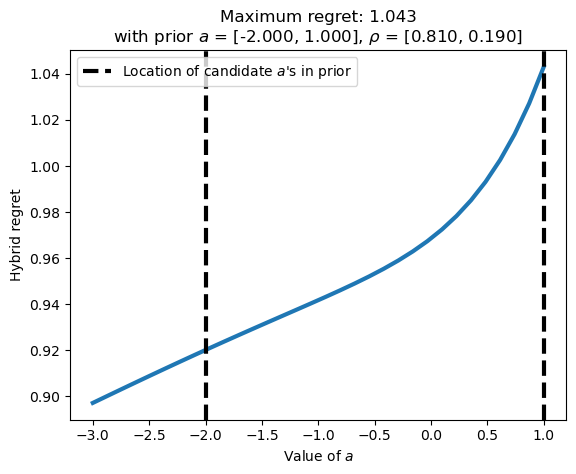

In [5]:
plot_regret(avec, arho, a_vals, regret_vals)

In this case, we note that the maximum regret happens at $𝑎 = 1$. This implies that maybe if we put more probability on this point, we would lower the total regret. Therefore, we now test with a new prior:

\begin{align}
a &= [-2,1] \\
\rho &= [0.19,0.81]
\end{align}


In [6]:
arho = arho[::-1]
regret2 = evaluate_regret(avec, arho, a_vals)

100%|███████████████████████████████████████████| 32/32 [00:48<00:00,  1.51s/it]


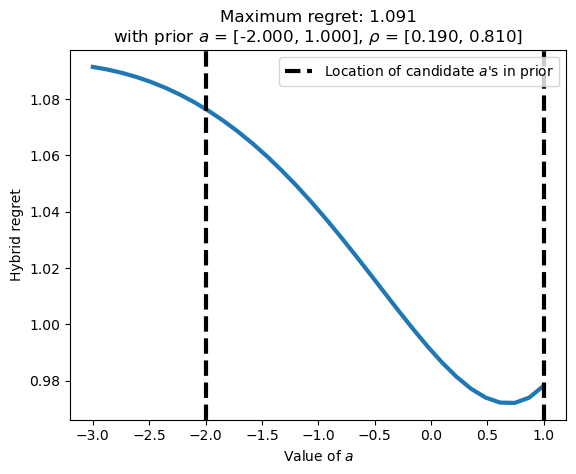

In [7]:
plot_regret(avec, arho, a_vals, regret2)

While the regret at $a = 1$ is much smaller than before, we have increased the regret at the negative $a$ values! So much so that the maximum regret is worse than before. However, some prior distribution between the two might lead to the a smaller maximum regret. 

# Optimizing the prior to achieve minimum regret

Assuming that the set of candidate $a$'s is a finite set with $N$ elements, there are a total of $2N-1$
independent parameters that define the prior of our Bayesian strategy: the $N$
values of the points, denoted $\{a_1,\ldots,a_N\}$, together with $N-1$
probabilities (the remaining probability is determined since probabilities sum
to 1). With these $2N-1$ parameters as our decision variables, we now seek
$2N-1$ conditions, which will allow us to minimize the worst-case regret, starting with a guess for the prior and using an
appropriate iterative minimization algorithm.

Firstly, we found that the regret at all $a_i$ must be equal (for details, see the above-mentioned pre-prints), i.e.,
\begin{align}
  R(a_i) = R(a_{i+1}), \quad i=1,\ldots,N-1.
  \end{align}
Secondly, the maximum regret must occur exactly at those values:
\begin{align}
    \left.\frac{\partial R}{\partial a}\right\rvert_{a=a_i} = 0,  \quad
  i=1,\ldots,N.
\end{align}

One last caveat needs to be considered: the above equations are not sufficient conditions for maximality, as they
simply show that the parameter values are critical points. Therefore, once we
have converged to a solution, we calculate the regret for all possible $a$ to ensure
that regret is indeed maximized on our candidates. 

We use an elementary Newton solver to produce solutions of the above equations, given a finite horizon $T$ and an initial
guess for the prior $\rho$. 


In [8]:
newton = tp2.NewtonSolver(1e-4, 1e-3)

In [9]:
avec, arho, regret = newton.Solver(grid, avec, arho, params)

Iteration 1:
  residual = 0.12312952244706099
  before update: ap = 1.0, am = -2.0, p = 0.81
  after update:  ap = 1.0, am = -1.9158773449609252, p = 0.5829490253051105
Iteration 2:
  residual = 0.016163451883351443
  before update: ap = 1.0, am = -1.9158773449609252, p = 0.5829490253051105
  after update:  ap = 1.0, am = -1.9731659555469458, p = 0.5496943339316831
Iteration 3:
  residual = 0.00019768029297217993
  before update: ap = 1.0, am = -1.9731659555469458, p = 0.5496943339316831
  after update:  ap = 1.0, am = -1.9812280735405143, p = 0.5501594200371429
Iteration 4:
  residual = 5.60613199307447e-07
  before update: ap = 1.0, am = -1.9812280735405143, p = 0.5501594200371429
  after update:  ap = 1.0, am = -1.9812412652649976, p = 0.5501610809735094


100%|███████████████████████████████████████████| 32/32 [00:47<00:00,  1.48s/it]


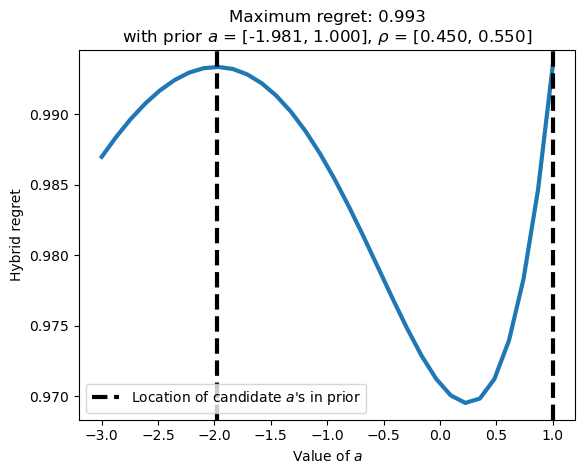

In [10]:
regret3 = evaluate_regret(avec, arho, a_vals)
plot_regret(avec, arho, a_vals, regret3)

We note that this fulfils all the criteria we set out when defining the optimization problem, and thus, the maximum regret is minimized. The above procedure is independent of the number of candidates we have in our prior, and the code generalizes to any number of possible a's and uses the same interface. However, the number of evaluations of the jacobian is on the order of $O(2N)^2$, so we have restricted ourselves to the two candidate case here for faster computation. 

# Conclusion

The above demonstrates that the PDEs posed above have numerical solutions that can be used to obtain the optimal Bayesian prior. We have restricted ourselves to a relatively small final time ($T=1$), but numerical experiments show that the number of required candidates increases as time increases. As we increased our final time, we would use the obtained optimal prior from the previous maximum time as the initial condition for the optimization procedure. As we repeat this procedure with increasing $T$, there might come a point where a value of $a$ that is not in the set of $N$ candidates (which all have equal regret and are local extrema) may have higher regret than the candidates. If this occurs, we determine the point of maximality, include this in the set of candidates (now of size $N+1$) and repeat the above process to obtain a new prior with this additional point.